**Explanation**

## Bipartite Ranking Algorithm
This notebook implements a bipartite ranking algorithm that ranks items based on user ratings while iteratively refining user reputations. The goal is to achieve a fair ranking system where user biases are minimized.

### **How it Works**
1. **Initialize User Reputation**: All users start with equal reputation.
2. **Compute Item Rankings**: Item scores are calculated using weighted user ratings.
3. **Update User Reputation**: Users with large rating errors are penalized.
4. **Iterate Until Convergence**: The process is repeated until rankings stabilize.

This notebook will:
- Load the dataset.
- Apply the bipartite ranking algorithm.
- Visualize the resulting item rankings.




**1.    Imports**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

**2.    Load Dataset**


In [3]:
# Define dataset path
file_path = "/home/martim/Desktop/tese/datasets/book_crossing/book_ratings_normalized.dat"

# Load dataset
df = pd.read_csv(file_path, sep='\t', header=0)  # Properly use the first row as headers

# Display first few rows
df.head()


,user_id,item_id,rating,normalized_rating,Unnamed: 4
0,1,6264,7.0,0.7,NaN
1,1,4350,7.0,0.7,NaN
2,1,6252,5.0,0.5,NaN
3,1,202,9.0,0.9,NaN
4,1,6266,6.0,0.6,NaN


**3.    Bipartite Ranking Algorithm**

In [1]:
def bipartite_ranking_algorithm(df, lambda_factor=0.3, tol=1e-6, max_iter=50):
    # Get unique users and items
    users = df["user_id"].unique()
    items = df["item_id"].unique()
    
    # Initialize user reputations (equal for all users)
    user_reputation = {user: 1.0 for user in users}
    
    for iteration in range(max_iter):
        prev_item_rankings = {} if iteration == 0 else item_rankings.copy()

        # Update item rankings
        item_rankings = {}
        for item in items:
            item_ratings = df[df["item_id"] == item]  # Ratings for the specific item
            users_who_rated = item_ratings["user_id"].values
            
            if len(users_who_rated) == 0:
                continue
            
            weighted_sum = sum(float(user_reputation[u]) * float(r) 
                               for u, r in zip(users_who_rated, item_ratings["normalized_rating"].values))
            total_weight = len(users_who_rated)
            
            item_rankings[item] = weighted_sum / total_weight if total_weight > 0 else 0
        
        # Update user reputations
        for user in users:
            user_ratings = df[df["user_id"] == user]
            items_rated = user_ratings["item_id"].values
            
            if len(items_rated) == 0:
                continue
            
            rating_errors = [abs(r - item_rankings[i]) for i, r in zip(items_rated, user_ratings["normalized_rating"].values)]
            avg_error = sum(rating_errors) / len(rating_errors)
            
            user_reputation[user] = 1 - lambda_factor * abs(avg_error)
            user_reputation[user] = max(user_reputation[user], 0)  # Ensure non-negative reputation
        
        # Check for convergence
        if iteration > 0:
            ranking_diff = sum(abs(prev_item_rankings[i] - item_rankings[i]) for i in items)
            if ranking_diff < tol:
                break
    
    return item_rankings


**4. Compute Item Rankings**


In [ ]:
# Compute rankings using the bipartite ranking algorithm
rankings = bipartite_ranking_algorithm(df)

# Display top-ranked items
sorted_rankings = sorted(rankings.items(), key=lambda x: x[1], reverse=True)
sorted_rankings[:10]


[(1470, 0.9902884615384615),
 (487, 0.9898942307692308),
 (12017, 0.9895),
 (404, 0.98675),
 (3732, 0.98675),
 (16217, 0.9864519222396377),
 (13544, 0.9858329798503046),
 (16151, 0.9845909565580618),
 (1058, 0.9843056972789116),
 (11566, 0.9834503278979085)]

**5. Visualizing the Distribution of Item Rankings**

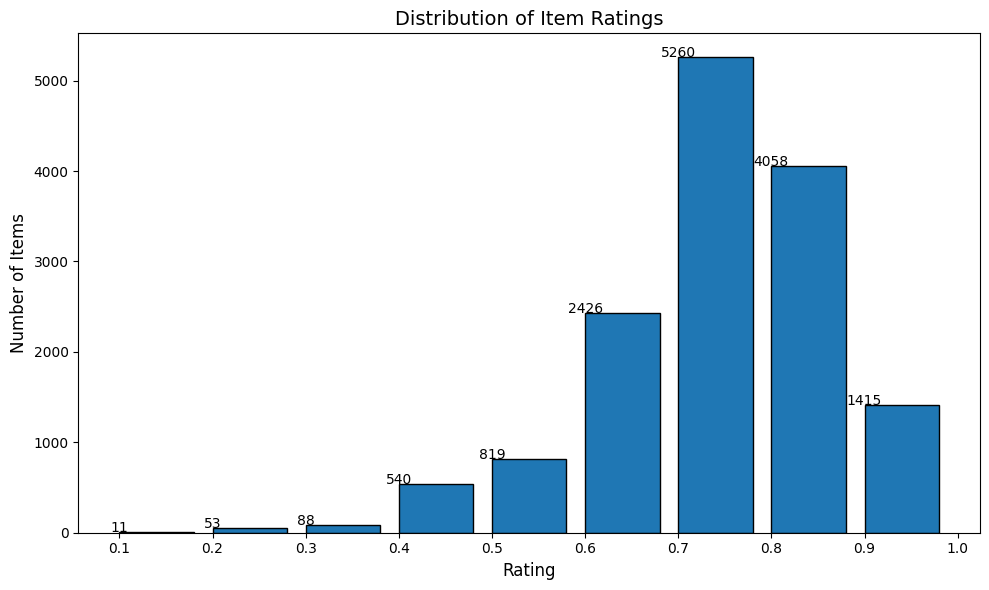

In [6]:
# Extract the ratings from the rankings
ratings = list(rankings.values())

# Define bins for the ratings (from 0.1 to 1.0 with steps of 0.1)
bins = np.arange(0.1, 1.1, 0.1)

# Count how many items fall into each rating bin
hist, bin_edges = np.histogram(ratings, bins=bins)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(hist)):
    plt.text(bin_edges[i], hist[i] + 1, str(hist[i]), ha='center', fontsize=10)

# Finalize the plot
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.title('Distribution of Item Ratings', fontsize=14)
plt.xticks(bins)  # Ensure the x-ticks correspond to the rating bins
plt.tight_layout()
plt.show()


**6. Metrics**


**6.1   Effectiveness**

In [27]:
def compute_aggregated_average_ranking(df):
    return df.groupby("item_id")["normalized_rating"].mean().to_dict()

def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Ensure only common items are compared
    
    if len(common_items) < 2:  # Need at least two rankings to compute Kendall's tau
        return 0
    
    sorted_items = sorted(common_items)  # Sort items to ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

# Compute the aggregated average ranking
aa_rankings = compute_aggregated_average_ranking(df)

# Compute Kendall’s tau for the entire dataset
tau_value = compute_kendall_tau(rankings, aa_rankings)
print(f"Kendall’s τ: {tau_value:.4f}")



Kendall’s τ: 0.9620


**6.2   Bias**

In [ ]:
bla bla